In [24]:
import numpy as np
from openai import OpenAI
import pandas as pd
import plotnine as p
import pymde
import sklearn
import sklearn.metrics
from tqdm import tqdm

In [2]:
data = pd.read_csv('https://nxn.se/single-cell-studies/data.tsv', sep='\t')

In [3]:
data['Title']

0       Classification of fusiform neocortical interne...
1                  Combinatorial Receptor Codes for Odors
2       Single-Cell Transcriptional Analysis of Neuron...
3       Cortical Sources of CRF, NKB, and CCK and Thei...
4       An improved single-cell cDNA amplification met...
                              ...                        
1928    Yolk sac cell atlas reveals multiorgan functio...
1929    Peripheral immune landscape for hypercytokinem...
1930    Maternal and embryonic signals cause functiona...
1931    Single-cell atlas reveals correlates of high c...
1932    Ikaros is a principal regulator of Aire <sup>+...
Name: Title, Length: 1933, dtype: object

In [4]:
data['DOI'].value_counts().reset_index().query('count > 1')

,DOI,count
0,10.1038/s41467-019-14081-6,2
1,10.1038/s41467-020-15411-9,2
2,10.1038/s41467-020-15543-y,2
3,10.1038/s41586-021-04369-3,2


In [10]:
# Removed those entries

In [11]:
data = pd.read_csv('https://nxn.se/single-cell-studies/data.tsv', sep='\t')

In [12]:
data['DOI'].value_counts().reset_index().query('count > 1')

,DOI,count


In [32]:
# Exact matching titles

In [35]:
data['Title'].value_counts().reset_index().query('count > 1')['Title'].to_list()

['Single-cell RNA-sequencing reveals predictive features of response to pembrolizumab in Sézary syndrome',
 'Single-cell analyses identify circulating anti-tumor CD8 T cells and markers for their enrichment',
 'Efficient combinatorial targeting of RNA transcripts in single cells with Cas13 RNA Perturb-seq',
 'Integrating single-cell RNA-seq and imaging with SCOPE-seq2',
 'A single cell transcriptional atlas of early synovial joint development']

In [36]:
# Removed those

In [37]:
data = pd.read_csv('https://nxn.se/single-cell-studies/data.tsv', sep='\t')

In [39]:
data['Title'].value_counts().reset_index().query('count > 1')['Title'].to_list()

[]

In [38]:
# Slight duplicates

In [40]:
client = OpenAI()

In [41]:
responses = []
for chunk in tqdm(np.array_split(data, 10)):
    query = chunk['Title'].to_list()
    response = client.embeddings.create(input = query, model = 'text-embedding-ada-002')
    responses += [response]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.06s/it]


In [42]:
embeddings_list = []
for response in responses:
    embeddings = np.array([d.embedding for d in response.data])
    embeddings_list += [embeddings]

In [43]:
embeddings = np.vstack(embeddings_list)

In [44]:
pdists = sklearn.metrics.pairwise_distances(embeddings)

In [45]:
mask = np.triu(np.ones(pdists.shape), k = 1).astype(bool)
pdistsl = pd.DataFrame(pdists).where(mask).stack().reset_index()

In [46]:
top_similar = pdistsl.sort_values(0).head(20)

In [47]:
for _, r in top_similar.iterrows():
    print('Distance:', r[0])
    d_r_0 = data.iloc[r['level_0'].astype(int)]
    d_r_1 = data.iloc[r['level_1'].astype(int)]
    print(d_r_0['DOI'], '\n|', d_r_0['Title'])
    print(d_r_1['DOI'], '\n|', d_r_1['Title'])
    print()

Distance: 0.04542879727657215
10.1101/2020.10.07.329839 
| Single-nucleus transcriptome analysis reveals cell type-specific molecular signatures across reward circuitry in the human brain
10.1016/j.neuron.2021.09.001 
| Single-nucleus transcriptome analysis reveals cell-type-specific molecular signatures across reward circuitry in the human brain

Distance: 0.051210665464434646
10.1101/2020.07.11.193458 
| Single-nucleus RNA-seq2 reveals a functional crosstalk between liver zonation and ploidy
10.1038/s41467-021-24543-5 
| Single-nucleus RNA-seq2 reveals functional crosstalk between liver zonation and ploidy

Distance: 0.07003401486501365
10.1101/2020.03.02.955757 
| Diversification of molecularly defined myenteric neuron classes revealed by single cell RNA-sequencing
10.1038/s41593-020-00736-x 
| Diversification of molecularly defined myenteric neuron classes revealed by single-cell RNA sequencing

Distance: 0.08156853865981699
10.1101/2021.07.19.452956 
| The Tabula Sapiens: a multip

In [51]:
top_similar = pdistsl.sort_values(0).iloc[20:30]

In [52]:
for _, r in top_similar.iterrows():
    print('Distance:', r[0])
    d_r_0 = data.iloc[r['level_0'].astype(int)]
    d_r_1 = data.iloc[r['level_1'].astype(int)]
    print(d_r_0['DOI'], '\n|', d_r_0['Title'])
    print(d_r_1['DOI'], '\n|', d_r_1['Title'])
    print()

Distance: 0.30166526498233476
10.1101/648642 
| A cellular atlas of the developing meninges reveals meningeal fibroblast diversity and function
10.1016/j.devcel.2020.06.009 
| Single-Cell Transcriptomic Analyses of the Developing Meninges Reveal Meningeal Fibroblast Diversity and Function

Distance: 0.30574903450084506
10.1242/dev.173807 
| Single cell transcriptomics reveals spatial and temporal dynamics of gene expression in the developing mouse spinal cord
10.1101/2020.03.16.992958 
| Single-cell transcriptomic analysis of the adult mouse spinal cord

Distance: 0.3067554463622778
10.1016/j.cell.2015.04.001 
| Single-Cell Transcriptome Analyses Reveal Signals to Activate Dormant Neural Stem Cells
10.1016/j.stem.2015.07.002 
| Single-Cell Transcriptomics Reveals a Population of Dormant Neural Stem Cells that Become Activated upon Brain Injury

Distance: 0.31251587403057574
10.1038/nature25739 
| A molecular atlas of cell types and zonation in the brain vasculature
10.1101/2021.10.18.4

In [54]:
# This process removed 22 duplicates!

In [67]:
data.shape

(1924, 28)

In [53]:
mde = pymde.preserve_neighbors(embeddings).embed()

In [55]:
mde_a = mde.numpy()

In [56]:
mde_a

array([[ 0.14475524, -2.0531766 ],
       [-0.304117  , -1.7645601 ],
       [ 0.15866718, -0.91575366],
       ...,
       [ 0.18902579, -0.18376237],
       [ 0.9655612 , -1.5933845 ],
       [ 0.75019854,  1.0677631 ]], dtype=float32)

In [57]:
mdata = pd.DataFrame(mde_a, index = data.index, columns = ['mde_1', 'mde_2'])

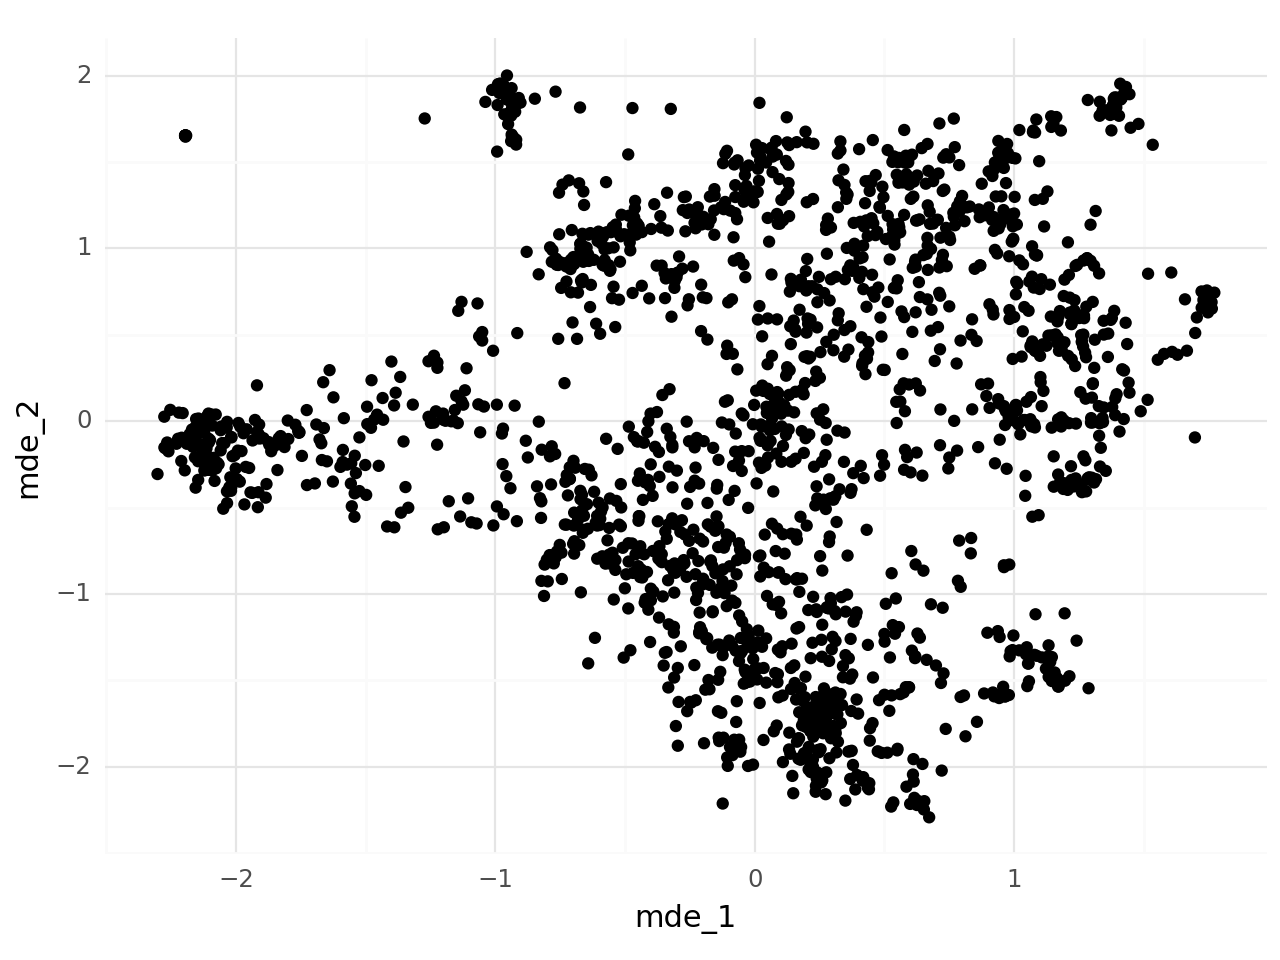

<Figure Size: (640 x 480)>

In [58]:
(
    p.ggplot(mdata, p.aes(x = 'mde_1', y = 'mde_2'))
    + p.geom_point()
    + p.theme_minimal()
)

In [62]:
idx_ = mdata.query('mde_1 < -2').query('mde_2 > 1').index

In [64]:
data.loc[idx_][['Shorthand', 'Title']]

,Shorthand,Title
197,Lonnberg et al SImmunology,Single-cell RNA-seq and computational analysis...
249,Poran et al Nature,Single-cell RNA sequencing reveals a signature...
326,Reid et al eLife,Single-cell RNA-seq reveals hidden transcripti...
757,Howick et al Science,The Malaria Cell Atlas: Single parasite transc...
841,Walzer et la PLoSGenetics,Latent transcriptional variations of individua...
904,Vigneron et al PNAS,Single-cell RNA sequencing of Trypanosoma bruc...
951,Xue et al eLife,A single-parasite transcriptional atlas of Tox...
1467,Real et al NCommunications,A single-cell atlas of Plasmodium falciparum t...
1591,Howick et al bioRxiv,Single-cell transcriptomics reveals expression...
1697,Ruberto et al bioRxiv,Single-cell RNA profiling of Plasmodium vivax ...


In [66]:
idx_ = mdata.query('1 < mde_1 < 2').query('1 < mde_2 < 2').index
data.loc[idx_][['Shorthand', 'Title']]

,Shorthand,Title
247,Wallrapp et al Nature,The neuropeptide NMU amplifies ILC2-driven all...
304,Russel et al eLife,Extreme heterogeneity of influenza virus infec...
413,Sjaastad et al PNAS,Distinct antiviral signatures revealed by the ...
497,Zanini et al PNAS,Virus-inclusive single-cell RNA sequencing rev...
551,Koutsakos et al NImmunology,Human CD8+ T cell cross-reactivity across infl...
610,Russel et al JVirology,Single-Cell Virus Sequencing of Influenza Infe...
750,Martin et al Cell,Single-Cell Analysis of Crohn’s Disease Lesion...
800,Wyler et al NCommunications,Single-cell RNA-sequencing of herpes simplex v...
809,Huang et al Cell,Mucosal Profiling of Pediatric-Onset Colitis a...
859,Darrah et al Nature,Prevention of tuberculosis in macaques after i...
